In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

2025-05-11 20:11:44.492557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746994304.666438      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746994304.717307      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_folder = '/kaggle/input/flickr8k/Images' # Path to the images folder in Google Drive.
captions_file = '/kaggle/input/flickr8k/captions.txt' # Path to captions.txt in Google Drive

captions = pd.read_csv(captions_file)  # Load captions from Google Drive
captions['image'] = captions['image'].apply(lambda x: os.path.join(image_folder, x)) # Update paths
captions.head()

,image,caption
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,/kaggle/input/flickr8k/Images/1000268201_693b0...,A girl going into a wooden building .
2,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse .
3,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
4,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl in a pink dress going into a woo...


In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  #Remove Extra Spaces, Punctuation
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'#Added Special tokens to mark beginning and ending
    return text

In [ ]:
#Text Preprocessing

captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,[start] a child in a pink dress is climbing up...
1,/kaggle/input/flickr8k/Images/1000268201_693b0...,[start] a girl going into a wooden building [end]
2,/kaggle/input/flickr8k/Images/1000268201_693b0...,[start] a little girl climbing into a wooden p...
3,/kaggle/input/flickr8k/Images/1000268201_693b0...,[start] a little girl climbing the stairs to h...
4,/kaggle/input/flickr8k/Images/1000268201_693b0...,[start] a little girl in a pink dress going in...


[start] a dog is jumping in the air with flowers in his mouth on a very windy day [end]



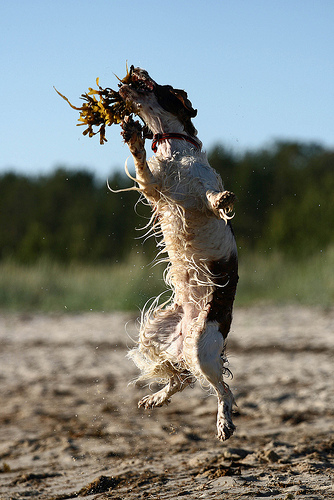

In [ ]:
#Display Random Picture and its caption

random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [ ]:
# ==== Vectorization & Model Hyperparameters ====

MAX_LENGTH = 40             # Maximum length of a caption (in number of tokens/words)
VOCABULARY_SIZE = 10000     # Maximum size of vocabulary (top 10,000 most frequent words)
BATCH_SIZE = 32             # Number of image-caption pairs processed per training step
BUFFER_SIZE = 1000          # Buffer size for shuffling the dataset
EMBEDDING_DIM = 512         # Dimensionality of word embeddings (input to decoder)
UNITS = 512                 # Hidden units in GRU/LSTM/Transformer layers

In [ ]:
# TextVectorization layer maps words to integer indices, Each word is assigned a unique ID between 1 and VOCABULARY_SIZE

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,         # Limit vocab size to most frequent words
    standardize=None,                   # ALready Processed
    output_sequence_length=MAX_LENGTH   # Pad or truncate captions to fixed length
)

tokenizer.adapt(captions['caption'])    #Function that will build the vocabulary

I0000 00:00:1746994317.302507      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746994317.303214      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
# === Convert words to indices and vice versa for easier reference ===

# word2idx: Convert string tokens to integer IDs (used in model training)

word2idx = tf.keras.layers.StringLookup(
    mask_token="",                              # Ignore the empty string
    vocabulary=tokenizer.get_vocabulary()      # Use the same vocabulary as the tokenizer
)

# idx2word: Convert integer IDs back to words (used during inference to generate captions)
idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
# Create a mapping: image filename → list of associated captions

img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())   # unique image paths (keys)
random.shuffle(img_keys)                     #unbiased training/validation split

slice_index = int(len(img_keys)*0.8)        # 20-8-0 SPLIT FOPR VALODATION AND TRAINIG
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],   # First 80% of image paths for training
                                          img_keys[slice_index:])


# === EXPAND TRAINING SET ===
train_imgs = []
train_captions = []
# For each training image, repeat it for each associated caption
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])         # How many captions it has
    train_imgs.extend([imgt] * capt_len)            # Duplicate the image path
    train_captions.extend(img_to_cap_vector[imgt])  # Add all captions

# === EXPAND VALIDATION SET ===
val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])         # Number of captions for val image
    val_imgs.extend([imgv] * capv_len)              # Repeat image path
    val_captions.extend(img_to_cap_vector[imgv])    # Add its captions

In [12]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(32360, 32360, 8095, 8095)

In [13]:
print(f"Type Val Img : {type(val_imgs)}")
print(f"Type Val Captions : {type(val_captions)}")

Type Val Img : <class 'list'>
Type Val Captions : <class 'list'>


In [ ]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)     #Load Image
    img = tf.io.decode_jpeg(img, channels=3)    #Load as tensor format
    img = tf.keras.layers.Resizing(299, 299)(img) 
    img = img / 255.    #Normalize img array
    caption = tokenizer(caption)
    return img, caption

In [ ]:
#dATASET OF image-caption pairs
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

#Load image and captions
train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#Valdataset samne way
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),   #Randomly flip image 
        tf.keras.layers.RandomRotation(0.2),        #Randomly Rotate image
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [ ]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )   #Pre-Trained inception v3 model, top classificatiuon layer removed
    
    inception_v3.trainable = False #No updatiom during training

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()#iNPUT TO ATTENTION
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()#OUTPUT FROM ATTENTION

        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim) #Attention mechanism
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)    #lAYER NORMALIZATION   
        x = self.dense(x)           #Dense Layer

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )   #multi-head attention mechanism

        x = self.layer_norm_2(x + attn_output)
        return x

In [ ]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)  #Converts input token ids into dense vectors
        
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))#Encodes the position of each token in the sequence


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]    #Len opf input sequence
        position_ids = tf.range(start=0, limit=length, delta=1) 
        position_ids = tf.expand_dims(position_ids, axis=0) #Expand pos to match batch size

        # Retrieve the embeddings for tokens (words) and their respective positions
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [20]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TensorShape([32, 40, 512])

In [ ]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)  # Word + Positional Embeddings

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )   # Self-attention (looks at previous tokens)

        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )    # Cross-attention (looks at encoder output - image features)

        self.layernorm_1 = tf.keras.layers.LayerNormalization() #Layer Normaliozations
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()
        
        # Feed-forward network (MLP block)
        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        # Final prediction layer - outputs probabilities for each token
        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        # Dropout layers to regularize the FFN output
        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        #Self-attention (decoder input attends to itself)
        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )
        out_1 = self.layernorm_1(embeddings + attn_output_1)

        #Cross-attention with encoder (attends to image features)
        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        # Feed-forward network (MLP)
        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)

        preds = self.out(ffn_out)   # Output token probabilities
        return preds


    #During training, when predicting next word, model can only attend to previous words and not "peek" into the future
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)         # Compute cross-entropy
        mask = tf.cast(mask, dtype=loss.dtype)   # Ensure mask is compatible type
        loss *= mask                             # Zero-out loss for padded tokens
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)  # Mean over non-pad tokens



    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)  # Token-wise match
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)  # Encoder on image features

        y_input = captions[:, :-1]  # Input to decoder (exclude last token)
        y_true = captions[:, 1:]   # Target output (exclude start token)
        mask = (y_true != 0)       # Mask to ignore padding (token ID 0)

        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )

        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc



    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)  # Apply augmentation if available

        img_embed = self.cnn_model(imgs)  # Extract features from image

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(img_embed, captions)

        # Combine all trainable variables (encoder + decoder)
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )

        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))  # Optimizer step

        # Update tracked metrics
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 4)  # Increase from 1 to 4 layers
decoder = TransformerDecoderLayer(EMBEDDING_DIM, 768, 12)  # Increase from UNITS=512, heads=8

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)





#patience=3: Training stops if validation loss does not improve for 3 consecutive epochs.
#restore_best_weights=True: Once stopped, the model's weights are reset to the best-performing epoch (based on validation loss), 
# preventing overfitting.


# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# # Replace simple Adam with scheduled learning rate
# learning_rate = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate=0.001, 
#     decay_steps=len(train_dataset) * 5  # 5 epochs worth of steps
# )
# optimizer = tf.keras.optimizers.Adam(learning_rate)
# caption_model.compile(optimizer=optimizer, loss=cross_entropy)

In [25]:
history = caption_model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20


I0000 00:00:1746994349.850212      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


1012/1012 ━━━━━━━━━━━━━━━━━━━━ 349s 321ms/step - acc: 0.1772 - loss: 5.3064 - val_acc: 0.2908 - val_loss: 4.0895
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 322s 317ms/step - acc: 0.3097 - loss: 3.8745 - val_acc: 0.3302 - val_loss: 3.6653
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 322s 317ms/step - acc: 0.3439 - loss: 3.4794 - val_acc: 0.3482 - val_loss: 3.5070
Epoch 4/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 325s 320ms/step - acc: 0.3616 - loss: 3.2836 - val_acc: 0.3569 - val_loss: 3.4412
Epoch 5/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 322s 317ms/step - acc: 0.3746 - loss: 3.1374 - val_acc: 0.3628 - val_loss: 3.4063
Epoch 6/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 322s 316ms/step - acc: 0.3847 - loss: 3.0316 - val_acc: 0.3667 - val_loss: 3.3859
Epoch 7/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 322s 316ms/step - acc: 0.3960 - loss: 2.9332 - val_acc: 0.3710 - val_loss: 3.3803
Epoch 8/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 321s 316ms/step - acc: 0.4027 - loss: 2.8561 - val_acc: 0.3733 - val_loss: 3.3906
Epoch 9/20
1012/101

In [41]:
idx2word(2).numpy().decode('utf-8')

'a'

In [ ]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)                          # Read image file as byte string
    img = tf.io.decode_jpeg(img, channels=3)                 # Decode JPEG into a tensor with 3 channels (RGB)
    img = tf.keras.layers.Resizing(299, 299)(img)            # Resize to 299x299 to match InceptionV3 input
    img = tf.cast(img, tf.float32) / 255.                    # Normalize pixel values to [0, 1]
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'                                        # Initialize caption with start token
    for i in range(MAX_LENGTH-1):                            # Loop through max allowed length
        tokenized = tokenizer([y_inp])[:, :-1]               # Convert current text into token IDs (exclude last token for prediction)
        mask = tf.cast(tokenized != 0, tf.int32)             # Create mask to ignore padding tokens
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)   # Predict next word using decoder


        pred_idx = np.argmax(pred[0, i, :])                  # Get index of the most probable token
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')   # Convert token index to actual word

        if pred_word == '[end]':                             # Stop generation if end token is predicted
            break
        y_inp += ' ' + pred_word                             # Append predicted word to input

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

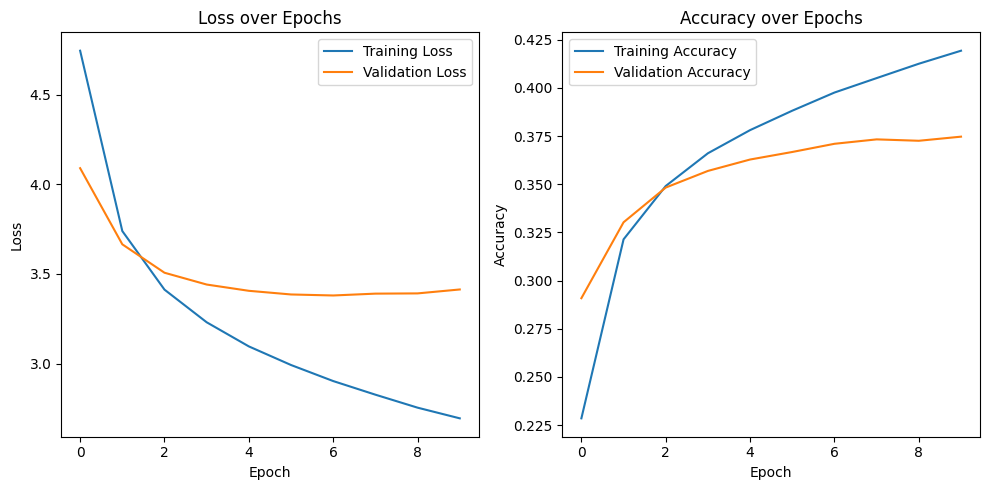

In [43]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history)

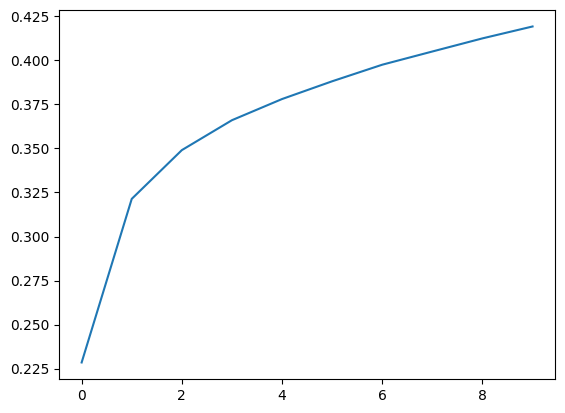

In [29]:
plt.plot(history.history['acc'])

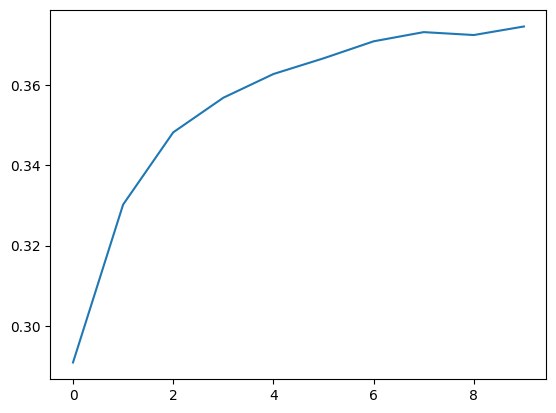

In [30]:
plt.plot(history.history['val_acc'])

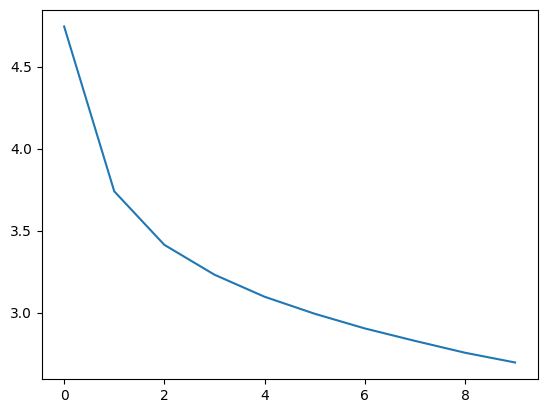

In [31]:
plt.plot(history.history['loss'])

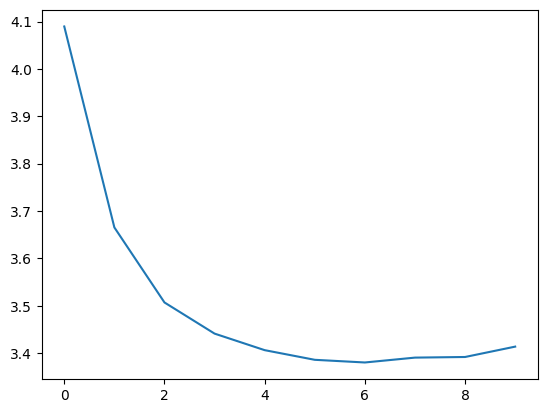

In [32]:
plt.plot(history.history['val_loss'])

Predicted Caption: a dog is running through the grass



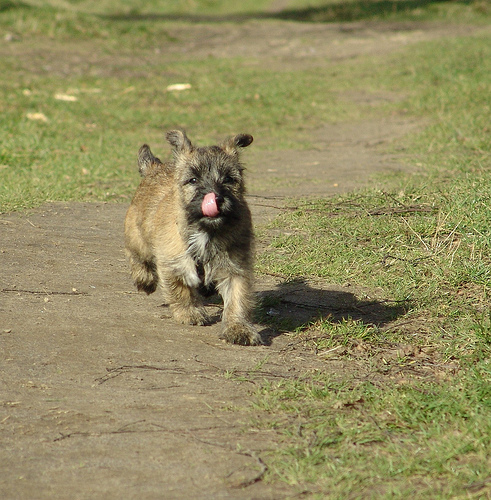

In [81]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: a dog is running through a field



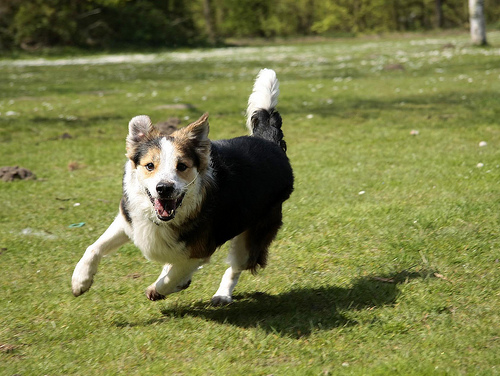

In [89]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: a man in a yellow shirt is riding a dirt bike



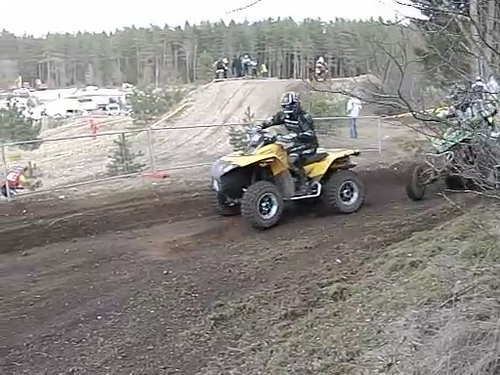

In [35]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: a boy in a red uniform is playing with a ball



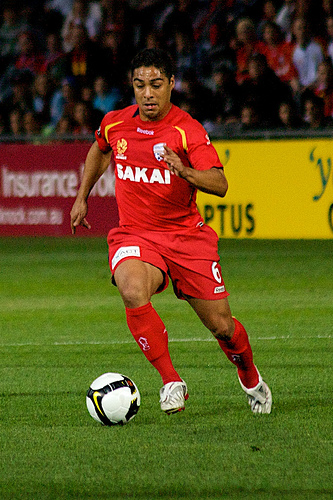

In [36]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: a man in a yellow shirt is riding a bike



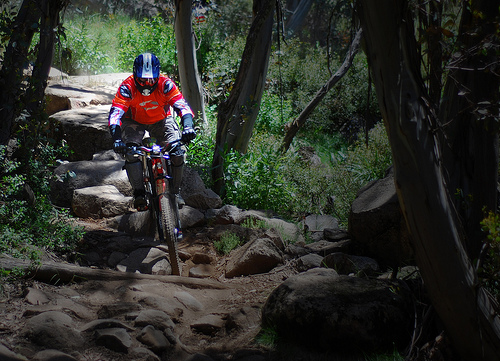

In [59]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: a dog is running through the water



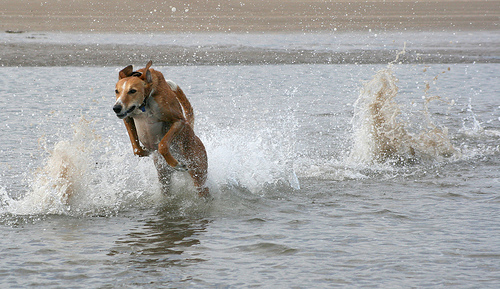

In [72]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [40]:
# caption_model.save_weights('image_captioning_transformer_weights.h5')

# if not load_weights:
#     from google.colab import drive
#     drive.mount('/content/drive')

# with open('/content/drive/MyDrive/Saved Models/ImageCaptioning/image_captioning_transformer_weights.h5', 'wb') as f:
#     f.write(open('image_captioning_transformer_weights.h5', 'rb').read())